In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio
import time
import pickle

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
from HN_decomposition.Subspace.ESPRIT_numpy import *
from HN_decomposition.Subspace.PQMF import *

def RMS(x):
        return np.std(x)

figsize = (9/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
## Base params

dpi = 300
cmap = 'gray_r'

## ESTER Criterion

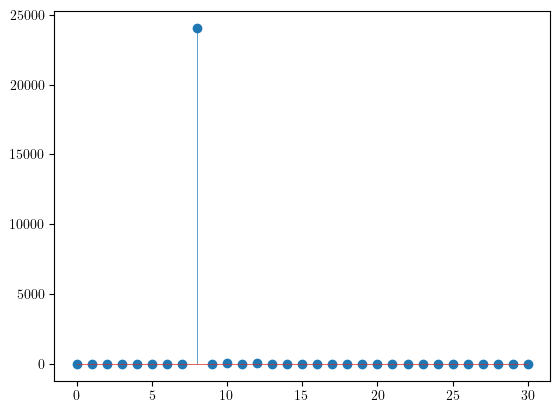

In [3]:
amps_nus = [[1, .1], [1, .2], [1, .4], [.9, .04]]

amp_noise = .1
length_smp = 512

x = np.zeros(length_smp, dtype= np.complex128)

for amp_nu in amps_nus:
    amp = amp_nu[0]
    nu = amp_nu[1]
    x += amp*np.sin(2*np.pi*nu*np.arange(length_smp))

x += amp_noise*np.random.randn(length_smp)


_, J_list = ESTER(
    x=x,
    start_idx = 15,
    window_length = 256,
    max_poles = 30,
    factor = 10
)

plt.stem(J_list)
plt.show()

## Loading the audio file

..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_1_P_2.mat
dict_keys(['__header__', '__version__', '__globals__', 'FRF', 'acc_t', 'fen_acc', 'fen_mar', 'freq', 'fs', 'mar_t', 'None', 'signal_accelero_fen', 'signal_marteau_fen', 'time', '__function_workspace__'])
sample rate : 51200 Hz


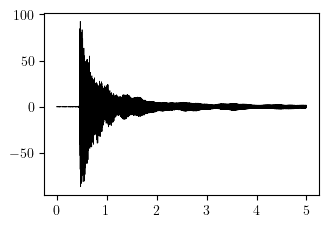

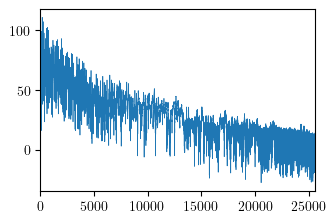

In [4]:
start_sec = .82
length_sec = 4

start_sec = 0
length_sec = 5

fileName = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM',
    'Medium_1', 'Corde_Acier', 'C_1_P_2.mat')
print(fileName)
data = scipy.io.loadmat(fileName)
print(data.keys())

sr_hz_old =  data['fs'][0,0]
x = data['acc_t'][int(sr_hz_old*start_sec):int(sr_hz_old*(start_sec+length_sec)),0].T
t = np.arange(len(x))/sr_hz_old

print(f'sample rate : {sr_hz_old} Hz')

plt.figure(figsize = figsize)
plt.plot(t,x,'k', linewidth = .5)
plt.show()

plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz_old), dB20(np.fft.rfft(x)))
#plt.semilogx()
plt.xlim(0, sr_hz_old/2)
plt.show()

## Resampling

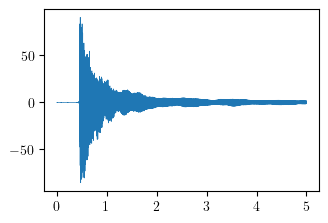

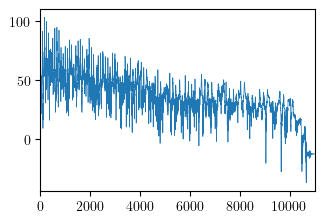

In [5]:
sr_hz = 22050
x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
t = np.arange(len(x))/sr_hz
plt.figure(figsize = figsize)
plt.plot(t,x)
plt.show()
plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz), dB20(np.fft.rfft(x)))
plt.xlim(0, sr_hz/2)
plt.show()

In [6]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Partials_Tracking", "Figures")

In [63]:
def compute_spectralCentroid(x_fft, f):
    x_fft_norm = np.abs(x_fft)
    x_fft_norm /= np.sum(x_fft_norm)
    return np.sum(x_fft_norm*f)/np.sum(x_fft_norm)

def compute_spectralBandwidth(x_fft, f, order, centroid = None):
    """
    from [1, p.135]

    References :
    ------------
    [1] Klapuri, Anssi, and Manuel Davy, eds. Signal Processing Methods for
    Music Transcription. New York: Springer, 2006.
    """
    if centroid == None:
        centroid = compute_spectralCentroid(x_fft, f)
    
    x_fft_norm = np.abs(x_fft)
    x_fft_norm /= np.sum(x_fft_norm)
    return np.power(np.sum(x_fft_norm*np.power(np.abs(f-centroid), order)), 1/order)

def compute_RMS(x):
    return np.sqrt(np.mean(np.square(x)))

def compute_ZCR(x):
    crossings = 0
    for i in range(len(x)-1):
        if x[i+1]*x[i]<0:
            crossings+=1
    return crossings/len(x)

def compute_features(x, sr, features_list, **kwargs):
    if 'bandwidth_order' in kwargs:
        bandwidth_order = kwargs['bandwidth_order']
    else:
        bandwidth_order = 2
    
    out = []

    x_fft = np.fft.rfft(x)
    f = np.fft.rfftfreq(len(x), 1/sr)
    centroid = None
    if 'centroid' in features_list:
        centroid = compute_spectralCentroid(x_fft, f)
        out.append(centroid)
    
    if 'bandwidth' in features_list:
        bandwidth = compute_spectralBandwidth(
            x_fft = x_fft, 
            f = f,
            order = bandwidth_order,
            centroid = centroid)
        out.append(bandwidth)
    
    if 'ZCR' in features_list:
        ZCR = compute_ZCR(x)
        out.append(ZCR)
    
    if 'RMS' in features_list:
        RMS = compute_RMS(x)
        out.append(RMS)
    
    return out


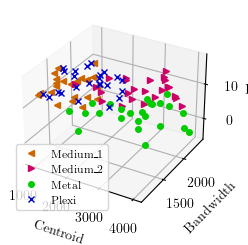

In [75]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 64

folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
#list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384


ax = plt.figure(figsize = figsize).add_subplot(projection = '3d')
for i, table_str in enumerate(list_tables):
    color  = color_list[i]
    marker = marker_list[i]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    ZCR_list = []
    for corde_str in list_cordes:
        for plectre_str in list_plectres:
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            
            start_idx = np.argmax(np.abs(sig.hilbert(x)))
            x = x[start_idx:start_idx+int(3*sr_hz_old)]
            x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            #xHarmo, xNoise = multiband_HN(
            #    np.real(x),
            #    tracking_method = 'FAPI',
            #    num_bands = num_bands,
            #    ester_factor=ester_factor,
            #    window_length=window_length,
            #    hop_length=hop_length,
            #    FAPI_beta = .95)
            
            x_fft = np.fft.rfft(x)
            f = np.fft.rfftfreq(len(x), 1/sr_hz)

            spectral_centroid = compute_spectralCentroid(
                x_fft, f)
            spectral_bandwidth = compute_spectralBandwidth(
                x_fft, f, order = 2, centroid = spectral_centroid)
            RMS = compute_RMS(x)
            ZCR = compute_ZCR(x)
            
            centroid_list.append(spectral_centroid)
            bandwidth_list.append(spectral_bandwidth)
            RMS_list.append(dB20(RMS))
            ZCR_list.append(ZCR)
    ax.plot(centroid_list, bandwidth_list, zs = RMS_list, linestyle = ' ', marker = marker, color = color, label = table_str, markersize = 4)
ax.set_xlabel('Centroid')
ax.set_ylabel('Bandwidth')
ax.set_zlabel('RMS')
#ax.set_title('Données mesurées')
plt.legend(prop = {'size' : 8})
plt.tight_layout()
plt.show()

            

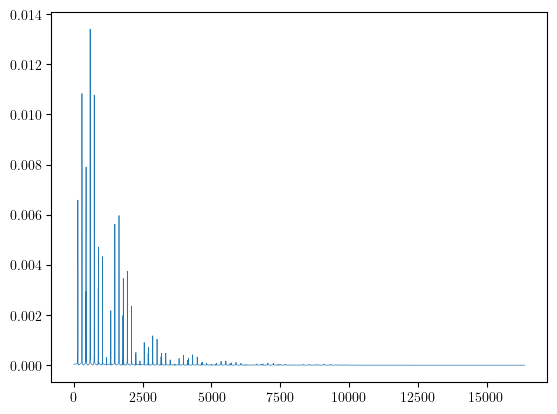

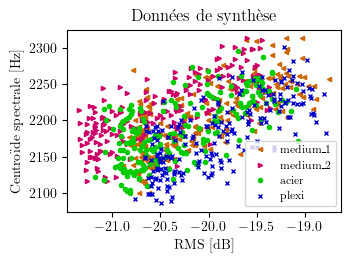

In [44]:
folder_mesures = os.path.join(
    '..',
    '..',
    'Dataset_1')

list_tables = ['medium_1', 'medium_2', 'acier', 'plexi']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384

file_name = os.path.join(
    folder_mesures,
    'acier',
    'Wav',
    '0' + '.wav')
sr_hz, x = scipy.io.wavfile.read(file_name)
x_fft = np.fft.rfft(x)
f = np.fft.rfftfreq(len(x), 1/sr_hz)

centroid_come = compute_spectralCentroid(x_fft, sr_hz)
centroid_libr = librosa.feature.spectral_centroid(x, sr = sr_hz, n_fft = len(x))
plt.plot(f, np.abs(x_fft/np.sum(np.abs(x_fft))))
plt.show()

plt.figure(figsize = figsize)
for i, table_str in enumerate(list_tables):
    color  = color_list[i]
    marker = marker_list[i]

    centroid_list = []
    bandwidth_list = []
    RMS_list = []
    for sample_idx in range(200):
        file_name = os.path.join(
            folder_mesures,
            table_str,
            'Wav',
            str(sample_idx) + '.wav'
        )
        sr_hz_old, x = scipy.io.wavfile.read(file_name)
        
        #x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
        sr_hz = sr_hz_old
        x = x[int(sr_hz*0):]
        t = np.arange(len(x))/sr_hz

        x_fft = np.fft.rfft(x)
        f = np.fft.rfftfreq(len(x), 1/sr_hz)

        spectral_centroid = compute_spectralCentroid(
            x_fft, f)
        spectral_bandwidth = compute_spectralBandwidth(
            x_fft, f, order = 2, centroid = spectral_centroid)
        RMS = compute_RMS(x)

        centroid_list.append(spectral_centroid)
        bandwidth_list.append(spectral_bandwidth)
        RMS_list.append(dB20(RMS))
    plt.plot(RMS_list, centroid_list, linestyle = ' ', marker = marker, color = color, label = table_str, markersize = 3)
    plt.ylabel('Centroïde spectrale [Hz]')
    plt.xlabel('RMS [dB]')
plt.title("Données de synthèse")
plt.legend(prop = {'size' : 8})
plt.show()

            

## Computing the harmonic+noise SNR

In [16]:
##Parameters
window_length = 32
hop_length = window_length//4
window_type = 'hann'
ester_factor = 10

num_bands = 64

folder_mesures = os.path.join(
    '..',
    '..',
    'Mesures',
    'Mesures_2023.01.27_LAM')

list_tables = ['Medium_1', 'Medium_2', 'Metal', 'Plexi']
list_cordes = ['C_1', 'C_2', 'C_3', 'C_4', 'C_5', 'C_6']
list_cordes = ['C_3']
list_plectres = ['P_1', 'P_2', 'P_3', 'P_4']

color_list = [(.8, .4, 0), (.8, 0, .4), (0, .8, 0), (0, 0, .8)]
marker_list = ['<', '>', 'o', 'x']
sr_hz = 16384

SNR_list = []
for i, table_str in enumerate(list_tables):
    for corde_str in list_cordes:
        for plectre_str in list_plectres:
            file_name = os.path.join(
                folder_mesures,
                table_str,
                'Corde_Acier',
                corde_str + '_' + plectre_str+ '.mat'
            )
            print(file_name)
            data = scipy.io.loadmat(file_name)
            sr_hz_old =  data['fs'][0,0]
            x = data['acc_t'][:,0].T
            x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
            t = np.arange(len(x))/sr_hz

            xHarmo, xNoise = multiband_HN(
                np.real(x),
                tracking_method = 'FAPI',
                num_bands = num_bands,
                ester_factor=ester_factor,
                window_length=window_length,
                hop_length=hop_length,
                FAPI_beta = .95)
            
            SNR_list.append(compute_RMS(xHarmo)/compute_RMS(xNoise))
            

..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_1.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_2.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_3.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_4.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_2\Corde_Acier\C_3_P_1.mat


c:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\io\matlab\_mio.py:227: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Consider mio5.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


..\..\Mesures\Mesures_2023.01.27_LAM\Medium_2\Corde_Acier\C_3_P_2.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_2\Corde_Acier\C_3_P_3.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Medium_2\Corde_Acier\C_3_P_4.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Metal\Corde_Acier\C_3_P_1.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Metal\Corde_Acier\C_3_P_2.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Metal\Corde_Acier\C_3_P_3.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Metal\Corde_Acier\C_3_P_4.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Plexi\Corde_Acier\C_3_P_1.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Plexi\Corde_Acier\C_3_P_2.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Plexi\Corde_Acier\C_3_P_3.mat
..\..\Mesures\Mesures_2023.01.27_LAM\Plexi\Corde_Acier\C_3_P_4.mat


In [17]:
SRN_list = np.array(SNR_list)

print(dB20(np.mean(SNR_list)))
print(dB20(np.std(SNR_list)))

17.77487357680212
8.385608961233936
